In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from t_sne import *
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE as s_TSNE

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import scanpy as sc 
import sklearn.metrics as sm
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

import pprint
import copy

## Data preparation

In [13]:
X = pd.read_csv("data/mnist_train.csv")
X_numpy = X.iloc[:600, 1:].to_numpy().astype('float64')
labels = X.iloc[:600, 0].values

In [14]:
print(X_numpy[:5])
print(X_numpy.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(6000, 784)


In [15]:
labels

array([5, 0, 4, ..., 8, 6, 9], dtype=int64)

## Evaluation functions

In [16]:
def get_src(data, embedding):
    original_distances = pdist(data, metric='euclidean')
    embedded_distances = pdist(embedding, metric='euclidean')
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)
    return spearman_corr

def plot_embedding(embedding, labels):
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    handles = []
    for i, label in enumerate(np.unique(labels)):
        handle = axs[0].scatter(embedding[labels==label, 0], embedding[labels==label, 1], s=1., label=label)
        handles.append(handle)

    axs[1].legend(handles, np.unique(labels), ncol=2)

    plt.xlabel("EMB1")
    plt.ylabel("EMB2")
    plt.show()

def get_clustering_metrics(embedding, labels):
    anndata = sc.AnnData(embedding)
    sc.pp.neighbors(anndata, use_rep="X")
    sc.tl.leiden(anndata)
    cluster_labels = anndata.obs["leiden"].values
    print("Number of Leiden clusters:", cluster_labels.shape)
    ari = sm.adjusted_rand_score(labels, cluster_labels)
    ami = sm.adjusted_mutual_info_score(labels, cluster_labels)
    homogeneity = sm.homogeneity_score(labels, cluster_labels)
    completeness = sm.completeness_score(labels, cluster_labels)
    print("""
    ARI: {}\n
    AMI: {}\n
    Homogenuity: {}\n
    Completeness: {}\n
    Avarage: {}
    """.format(ari, ami, homogeneity, completeness, ari+ami+homogeneity+completeness/4))
    return ari, ami, homogeneity, completeness

## Experiments

Most effective values:
- compression_period: 300

In [14]:
algo_config = {
    'num_iters':500,

    'learning_rate':10.,
    'momentum':0.9,
    'perplexity':20,

    'compression_period':300,
    'compression_term':1e-2,

    'points_part':0.9,
    'num_nn':20,
    'random_walk_num_iters':500,
}

In [8]:
tsne = TSNE(
        **algo_config,
        verbose=True,
        labels=labels)

In [ ]:
tsne.fit(X_numpy)
Y = tsne.transform()

plt.scatter(Y[:, 0], Y[:, 1], c=labels)
plt.show()

In [18]:
tsne = TSNE(
        **algo_config,
        random_walk=True,
        verbose=True,
        labels=labels)

Building graph...


100%|██████████| 400/400 [00:01<00:00, 203.24it/s]


Running RW...


100%|██████████| 500/500 [00:02<00:00, 239.00it/s]


Fraction of correct paths: 0.9893388888888889
Fraction of short circuits: 0.006866666666666667
Running gradient descent...


 19%|█▉        | 96/500 [00:00<00:04, 93.42it/s] 

Max difference between Y_1 and Y_2: 6.537900817989047e-07


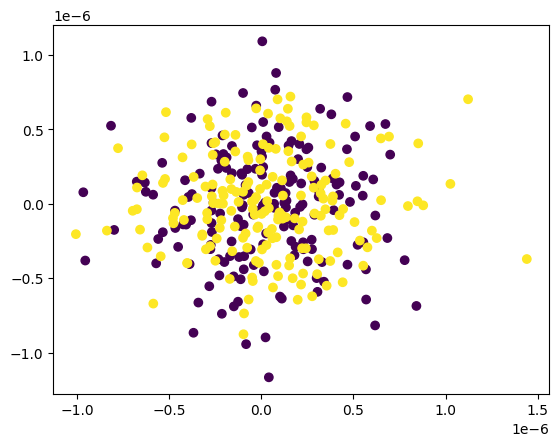

 39%|███▉      | 194/500 [00:02<00:03, 98.39it/s]

Max difference between Y_1 and Y_2: 3.004583587373004e-09


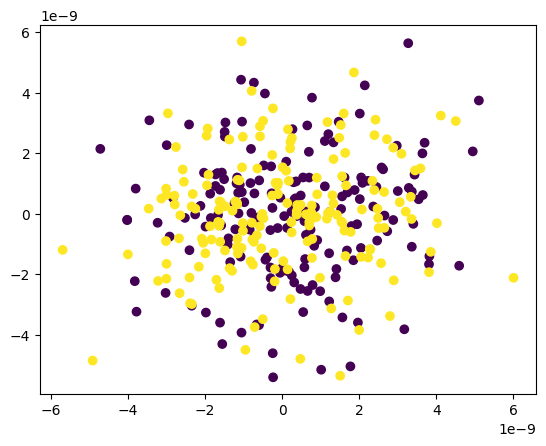

 59%|█████▊    | 293/500 [00:03<00:02, 99.77it/s] 

Max difference between Y_1 and Y_2: 1.760308702681931e-11


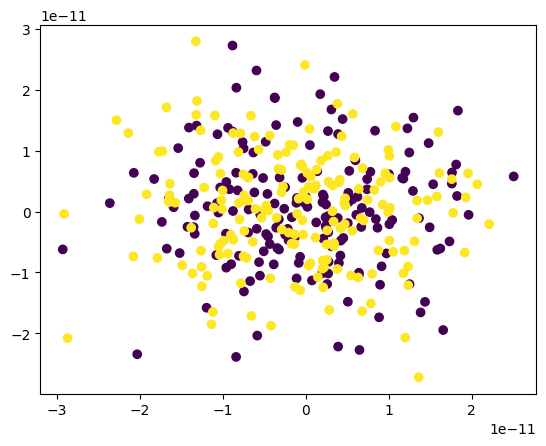

 79%|███████▊  | 393/500 [00:04<00:01, 78.82it/s] 

Max difference between Y_1 and Y_2: 0.1775714667321302


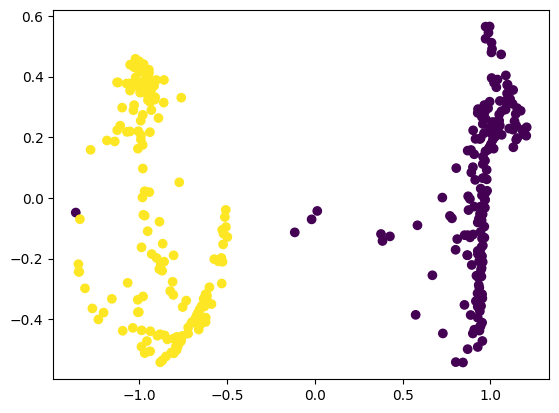

 97%|█████████▋| 484/500 [00:05<00:00, 102.78it/s]

Max difference between Y_1 and Y_2: 0.06500591536724354


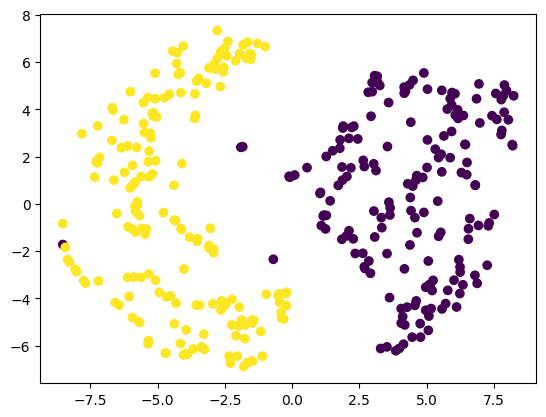

100%|██████████| 500/500 [00:05<00:00, 86.78it/s] 


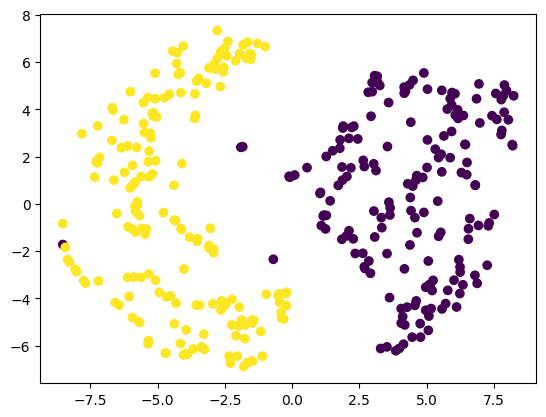

In [20]:
tsne.fit(X_numpy)
Y = tsne.transform()

landmarks_idx = tsne.landmarks_idx
plt.scatter(Y[:, 0], Y[:, 1], c=labels[landmarks_idx])
plt.show()

## Debugging

In [54]:
X_fixed = X_numpy
# X_fixed[X_fixed > 0] = 1
# X_fixed = X_fixed / 255

In [64]:
algo_config = {
    'num_iters':1000,

    'lr':10.,
    'momentum':0.9,
    'perplexity':20,

    'compression_period':300,
    'compression_term':1e-2,

    'points_part':0.5,
    'num_nn':20,
    'random_walk_num_iters':500,

    'seed': 0,
}

In [68]:
full_config = copy.deepcopy(algo_config)
full_config.update(algo_config)
pprint.PrettyPrinter(width=20).pprint(full_config)

{'compression_period': 300,
 'compression_term': 0.01,
 'digits': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'lr': 10.0,
 'momentum': 0.9,
 'num_iters': 1000,
 'num_nn': 20,
 'num_samples': 1000,
 'perplexity': 20,
 'points_part': 0.5,
 'random_walk_num_iters': 500,
 'seed': 0}


In [55]:
rw_tsne = TSNE(
        random_walk=True,
        **algo_config,
        verbose=True,
        color=labels,
        )

Building graph...


100%|██████████| 10000/10000 [08:53<00:00, 18.74it/s]


Running RW...


100%|██████████| 500/500 [00:24<00:00, 20.13it/s]


Fraction of correct paths: 0.8764056
Fraction of short circuits: 0.0411628
Running gradient descent...


 10%|▉         | 99/1000 [03:02<25:37,  1.71s/it] 

Max difference between Y_1 and Y_2: 9.040269754246487e-07


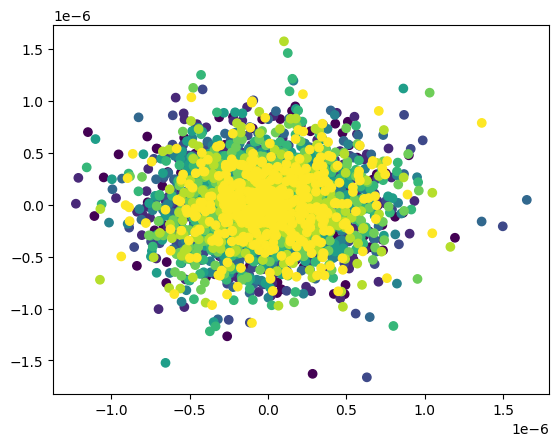

 20%|█▉        | 199/1000 [05:59<22:00,  1.65s/it]

Max difference between Y_1 and Y_2: 3.799867847259596e-09


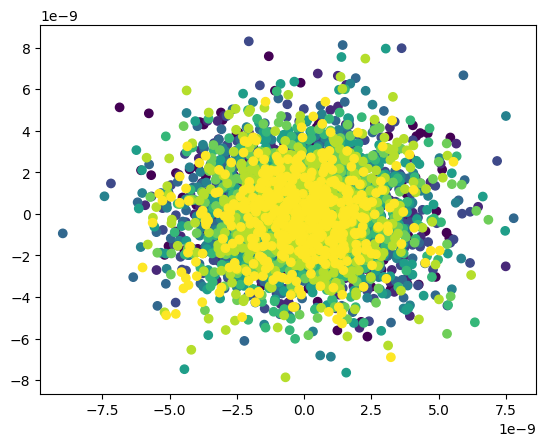

 30%|██▉       | 299/1000 [08:43<18:30,  1.58s/it]

Max difference between Y_1 and Y_2: 1.92373870465214e-11


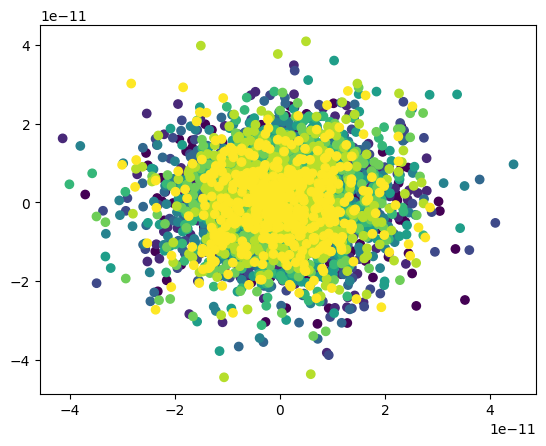

 40%|███▉      | 399/1000 [11:21<15:46,  1.57s/it]

Max difference between Y_1 and Y_2: 9.28822765430741e-11


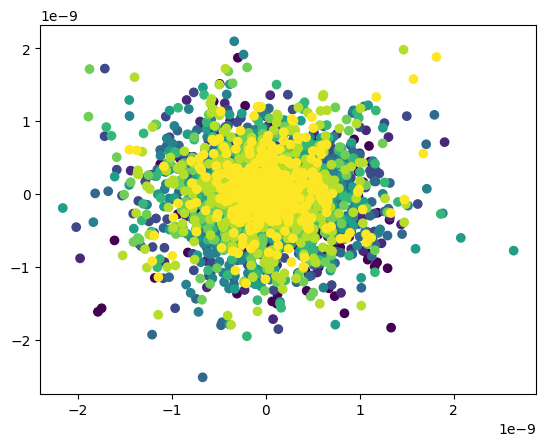

 50%|████▉     | 499/1000 [13:59<13:11,  1.58s/it]

Max difference between Y_1 and Y_2: 4.3565741179637445e-09


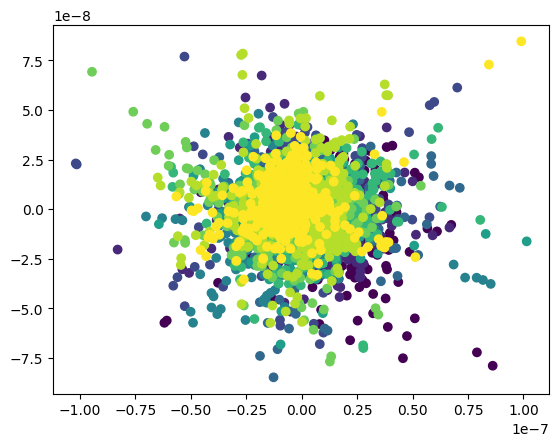

 60%|█████▉    | 599/1000 [16:36<10:30,  1.57s/it]

Max difference between Y_1 and Y_2: 3.241490301941842e-07


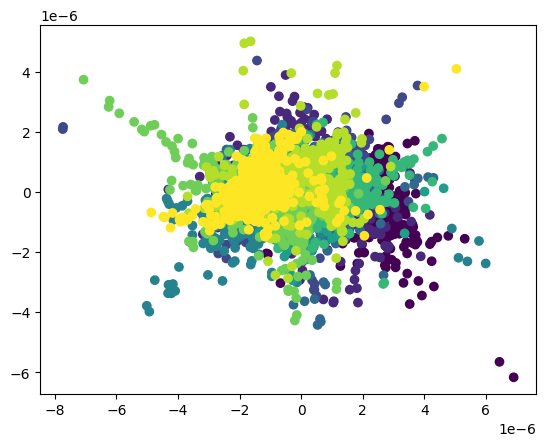

 70%|██████▉   | 699/1000 [19:13<07:51,  1.57s/it]

Max difference between Y_1 and Y_2: 3.251260146726884e-05


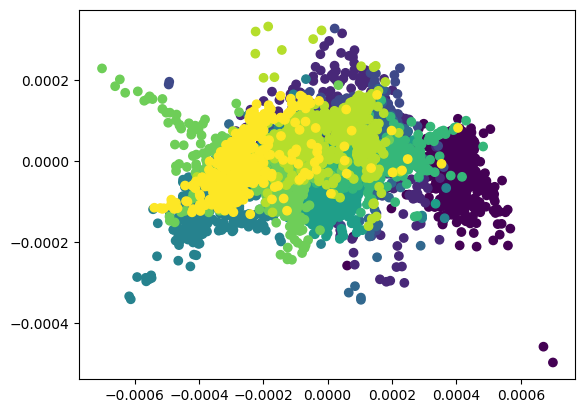

 80%|███████▉  | 799/1000 [21:51<05:17,  1.58s/it]

Max difference between Y_1 and Y_2: 0.004459248485047543


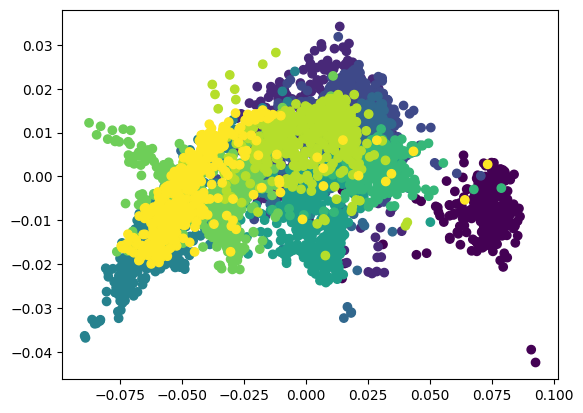

 90%|████████▉ | 899/1000 [24:29<02:39,  1.58s/it]

Max difference between Y_1 and Y_2: 0.02103110335987013


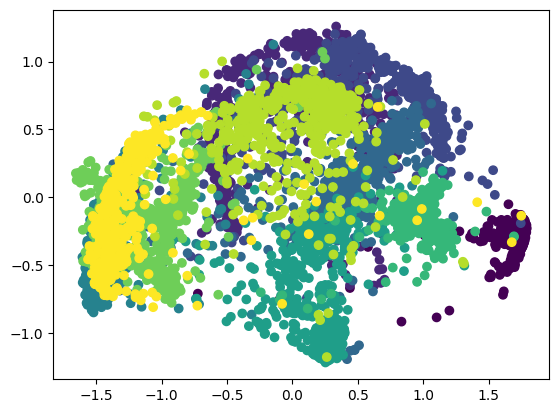

100%|█████████▉| 999/1000 [27:06<00:01,  1.57s/it]

Max difference between Y_1 and Y_2: 0.016891596173431056


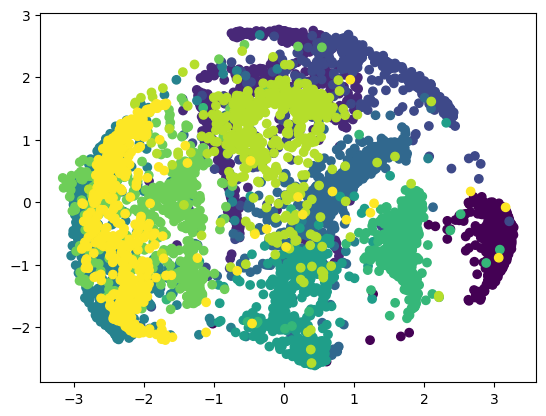

100%|██████████| 1000/1000 [27:08<00:00,  1.63s/it]


In [56]:
rw_tsne.fit(X_fixed)
rw_Y = rw_tsne.transform()

rw_p = rw_tsne.P

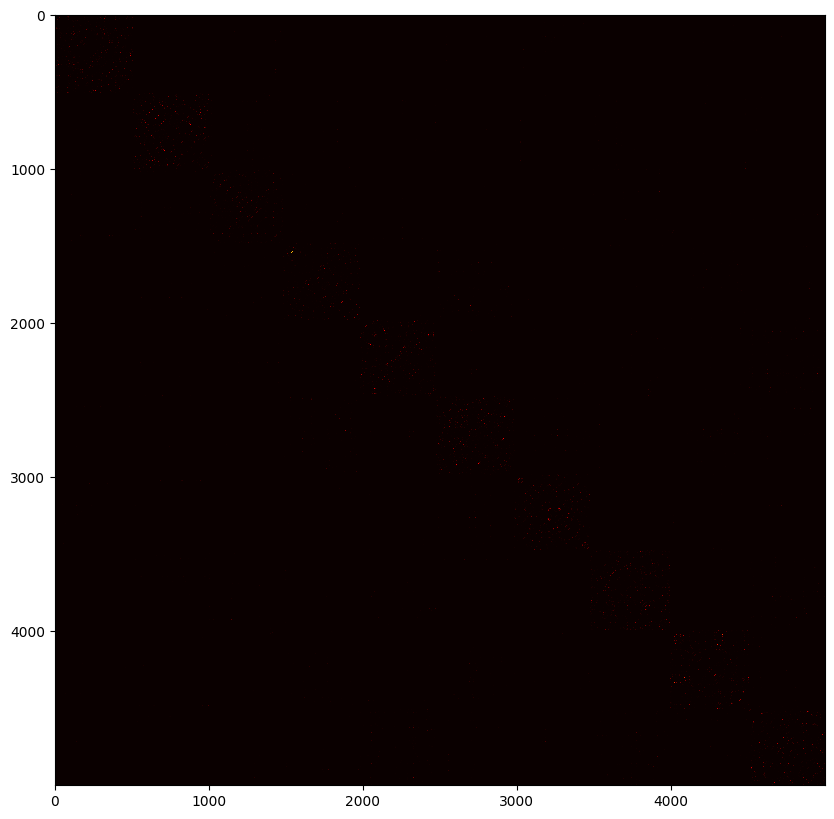

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(rw_p, cmap='hot', interpolation='nearest')
plt.show()

In [19]:
num_iters=500
perplexity=20
lr=10.
momentum=0.9
compression_period=300
compression_term=1e-2

ex_tsne = TSNE(n_components=2,
        num_iters=num_iters,
        perplexity=perplexity,
        learning_rate=lr,
        momentum=momentum,
        compression_period=compression_period,
        compression_term=compression_term,
        initialization="random",
        ee=False,
        ee_iterations=250,
        verbose=True,
        color=y_true,
        seed=0)

In [ ]:
ex_tsne.fit(X_fixed)

ex_p = ex_tsne.P

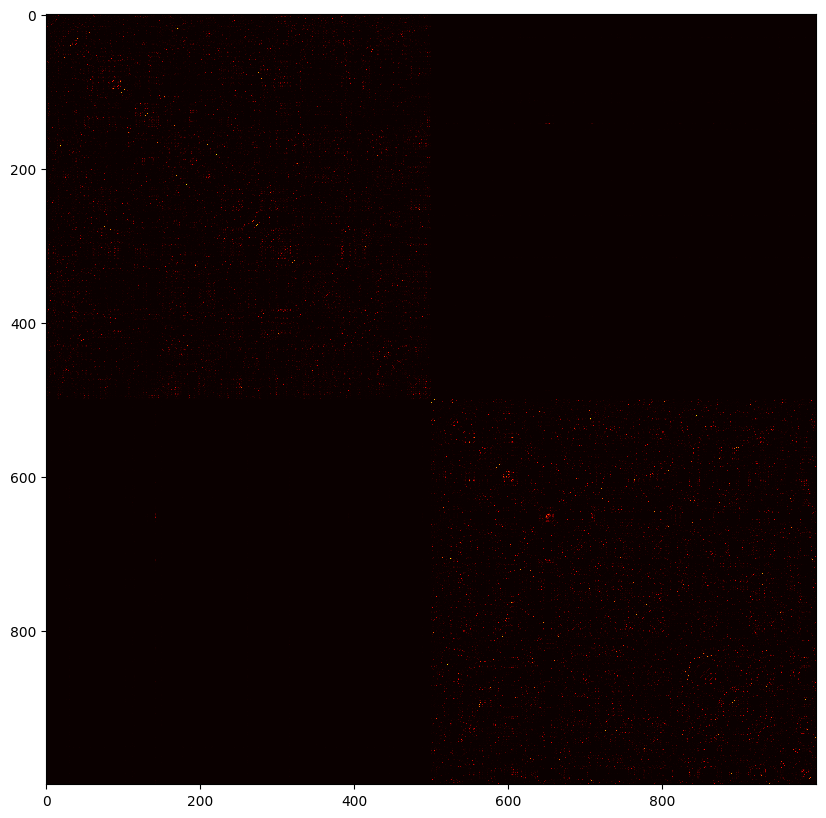

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(ex_p, cmap='hot', interpolation='nearest')
plt.show()

## Examples

In [51]:
a = np.array([[0, 1, 2],
              [3, 1, 2]])
np.square(np.linalg.norm(a[0] - a, axis=1))

array([0., 9.])

### Evaluation

In [18]:
# TODO: find labels for clustering
print("KL Divergence:", tsne.metrics['kl_divergence'])

KL Divergence: 0.6910360332469317


### sklearn

In [19]:
s_tsne = s_TSNE()
s_tsne.fit(X_numpy)

TSNE()

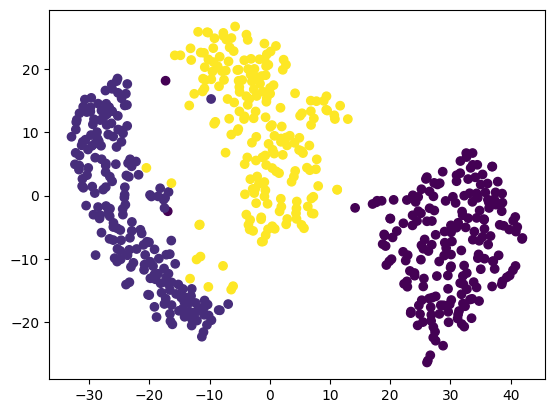

In [40]:
s_Y = s_tsne.embedding_
plt.scatter(s_Y[:, 0], s_Y[:, 1], c=y_true)
plt.show()

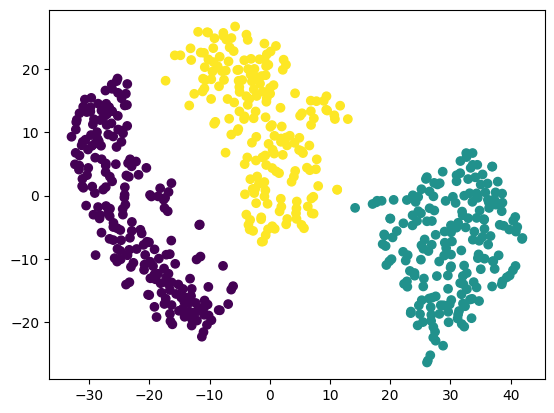

array([0, 1, 2])

In [47]:
anndata = sc.AnnData(s_Y)
sc.pp.neighbors(anndata, use_rep="X")
sc.tl.leiden(anndata, resolution=0.1)
leiden_labels = anndata.obs["leiden"].values

leiden_labels = np.array([int(i) for i in leiden_labels])
plt.scatter(s_Y[:, 0], s_Y[:, 1], c=leiden_labels)
plt.show()

np.unique(leiden_labels)

### K-means

In [32]:
kmeans = MiniBatchKMeans(n_clusters=3,
                        random_state=0,
                        batch_size=20,
                        max_iter=10,
                        n_init="auto").fit(Y)
y_hat = kmeans.labels_

In [33]:
print(y_true[:20])
print(y_hat[:20])

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: label, dtype: int64
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


### PCA

In [ ]:
pca = PCA()

pca.fit_transform(X_numpy)

cum_var_explained = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [ ]:
n_components = np.min(np.where(cum_var_explained > 0.9)[0])
n_components

In [ ]:
V = pca.components_[:n_components].T

X_transform = X_numpy @ V

print(X_transform.shape)

### Save

In [ ]:
with open("data/reduced.npy", "wb") as f:
    np.save(f, Y)